In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os
for dirname, _,filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input\test1.zip
./input\train.zip


In [10]:
import shutil
import tqdm

In [6]:
CONTENT_DIR = './content'

TRAIN_DIR = CONTENT_DIR + '/train'
TRAIN_DIR_DOG = TRAIN_DIR + '/dog'
TRAIN_DIR_CAT = TRAIN_DIR + '/cat'

VALID_DIR = CONTENT_DIR + '/valid'
VALID_DIR_DOG = VALID_DIR + '/dog'
VALID_DIR_CAT = VALID_DIR + '/cat'

In [7]:
import zipfile
with zipfile.ZipFile('./input/train.zip', 'r') as zipf:
    zipf.extractall(CONTENT_DIR)

In [8]:
img_filenames = os.listdir(TRAIN_DIR)
print('Num of images:', len(img_filenames))

dog_filenames = [fn for fn in img_filenames if fn.startswith('dog')]
cat_filenames = [fn for fn in img_filenames if fn.startswith('cat')]

dataset_filenames = train_test_split(
    dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
)

train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
train_total = train_dog_total + train_cat_total
valid_total = valid_dog_total + valid_cat_total
print('Train: {}, test: {}'.format(train_total, valid_total))

Num of images: 25000
Train: 22500, test: 2500


In [11]:
make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]
for dir, fns in zip(make_dirs, dataset_filenames):
    os.makedirs(dir, exist_ok=True)
    for fn in tqdm.tqdm(fns):
        shutil.move(os.path.join(TRAIN_DIR, fn), dir)
    print('elements in {}: {}'.format(dir, len(os.listdir(dir))))

100%|██████████| 11250/11250 [00:08<00:00, 1366.16it/s]


elements in ./content/train/dog: 11250


100%|██████████| 1250/1250 [00:00<00:00, 1564.72it/s]


elements in ./content/valid/dog: 1250


100%|██████████| 11250/11250 [00:06<00:00, 1681.84it/s]


elements in ./content/train/cat: 11250


100%|██████████| 1250/1250 [00:00<00:00, 2037.96it/s]

elements in ./content/valid/cat: 1250


In [42]:
BATCH_SIZE = 32
IMAGE_SHAPE = 128

In [13]:
train_generator = ImageDataGenerator(rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255)

In [44]:
train_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
valid_data = valid_generator.flow_from_directory(
    directory=VALID_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


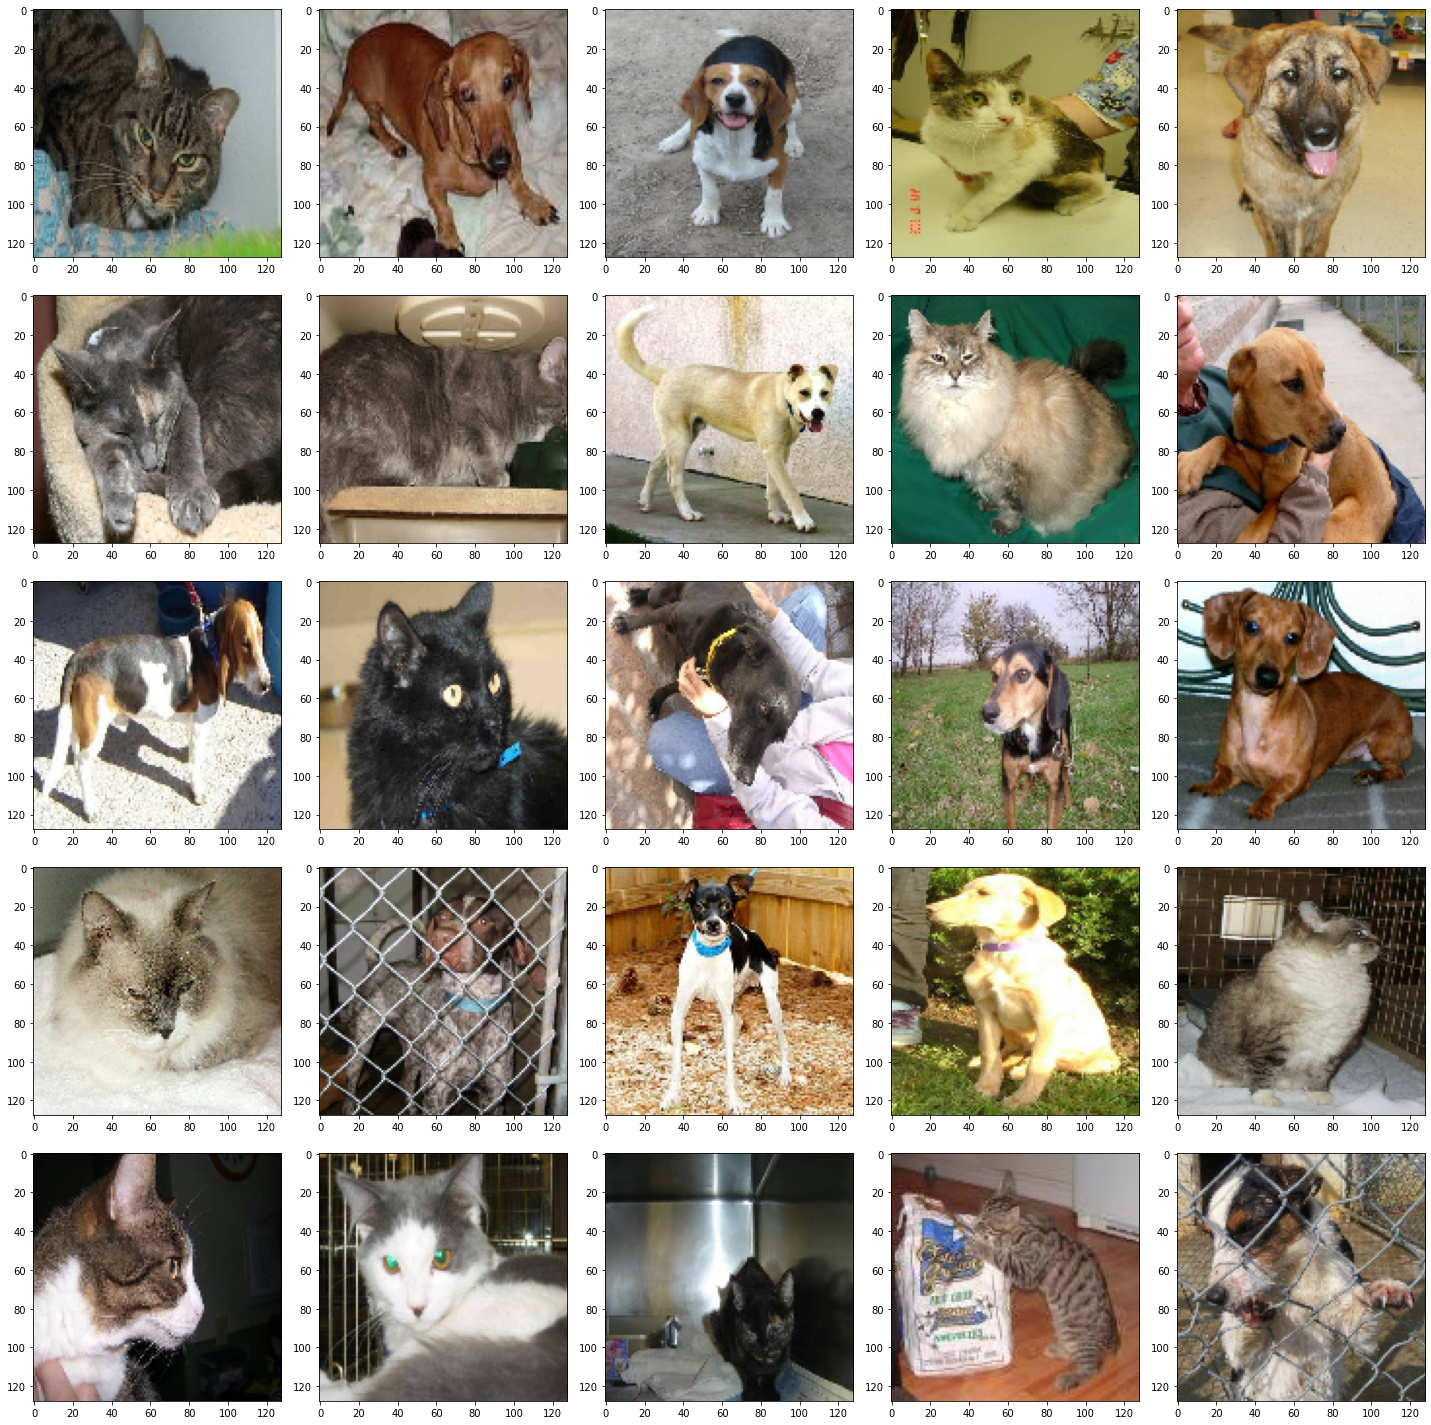

In [16]:
some_pets = next(train_data)[0][:25]
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
for img, ax in zip(some_pets, axes.flatten()):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [17]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(
#         filters=32,
#         kernel_size=(3, 3),
#         activation='relu',
#         input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)
#     ),
#     tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=512, activation='relu'),
#     tf.keras.layers.Dense(units=2, activation='softmax')
# ])

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [20]:
EPOCHS = 60

In [32]:
# history = model.fit_generator(
#     generator=train_data,
#     steps_per_epoch=(train_total + BATCH_SIZE - 1) // BATCH_SIZE,
#     epochs=EPOCHS,
#     validation_data=valid_data,
#     validation_steps=(valid_total + BATCH_SIZE - 1) // BATCH_SIZE,
# )

In [33]:
xception_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)

In [43]:
train_bottleneck = xception_model.predict(
    train_data, train_data.n // BATCH_SIZE, verbose=1
)

176/176 [==============================] - 46s 260ms/step


In [36]:
# bottleneck features for valid dataset
valid_bottleneck = xception_model.predict(
    valid_data, valid_data.n // BATCH_SIZE, verbose=1
)

20/20 [==============================] - 7s 355ms/step


In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu', input_shape=xception_model.output_shape[1:]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

In [38]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 557,698
Trainable params: 557,698
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
EPOCHS = 10
history = model.fit(
    x=train_bottleneck,
    y=train_data.labels[:len(train_bottleneck)],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_bottleneck, valid_data.labels[:len(valid_bottleneck)])
)

Epoch 1/10
176/176 [==============================] - 1s 5ms/step - loss: 0.7302 - accuracy: 0.4974 - val_loss: 0.6894 - val_accuracy: 0.4524
Epoch 2/10
176/176 [==============================] - 1s 3ms/step - loss: 0.6950 - accuracy: 0.5082 - val_loss: 0.6921 - val_accuracy: 0.5076
Epoch 3/10
176/176 [==============================] - 1s 3ms/step - loss: 0.6940 - accuracy: 0.5037 - val_loss: 0.6900 - val_accuracy: 0.4676
Epoch 4/10
176/176 [==============================] - 1s 3ms/step - loss: 0.6938 - accuracy: 0.5042 - val_loss: 0.7152 - val_accuracy: 0.5228
Epoch 5/10
176/176 [==============================] - 1s 3ms/step - loss: 0.6938 - accuracy: 0.5037 - val_loss: 0.6928 - val_accuracy: 0.5384
Epoch 6/10
176/176 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5066 - val_loss: 0.6931 - val_accuracy: 0.4876
Epoch 7/10
176/176 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6950 - val_accuracy: 0.4160
Epoch 

In [45]:
valid_data.labels

array([0, 0, 0, ..., 1, 1, 1])

In [46]:
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
CONTENT_DIR = './content'
TRAIN_DIR = CONTENT_DIR + '/train'
VALID_DIR = CONTENT_DIR + '/valid'

if not os.path.exists(CONTENT_DIR):
    # Extract dataset
    import zipfile
    with zipfile.ZipFile('./input/train.zip', 'r') as zipf:
        zipf.extractall(CONTENT_DIR)

    # Split cats and dogs images to train and valid datasets
    img_filenames = os.listdir(TRAIN_DIR)
    dog_filenames = [fn for fn in img_filenames if fn.startswith('dog')]
    cat_filenames = [fn for fn in img_filenames if fn.startswith('cat')]
    dataset_filenames = train_test_split(
        dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
    )

    # Move images
    make_dirs = [d + a for a in ['/dog', '/cat'] for d in [TRAIN_DIR, VALID_DIR]]
    for dir, fns in zip(make_dirs, dataset_filenames):
        os.makedirs(dir, exist_ok=True)
        for fn in tqdm.tqdm(fns):
            shutil.move(os.path.join(TRAIN_DIR, fn), dir)
        print('elements in {}: {}'.format(dir, len(os.listdir(dir))))
BATCH_SIZE = 32
IMAGE_SHAPE = 128
train_generator = ImageDataGenerator(rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255)
train_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
valid_data = valid_generator.flow_from_directory(
    directory=VALID_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
xception_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)
train_bottleneck = xception_model.predict_generator(
    train_data, train_data.n // BATCH_SIZE, verbose=1
)
valid_bottleneck = xception_model.predict_generator(
    valid_data, valid_data.n // BATCH_SIZE, verbose=1
)

./input\test1.zip
./input\train.zip
Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


C:\Users\prans\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


78/78 [==============================] - 5s 70ms/step


In [48]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu', input_shape=xception_model.output_shape[1:]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

In [49]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [50]:
EPOCHS = 10
history = model.fit(
    x=train_bottleneck,
    y=train_data.labels[:len(train_bottleneck)],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_bottleneck, valid_data.labels[:len(valid_bottleneck)])
)

Epoch 1/10
703/703 [==============================] - 2s 3ms/step - loss: 0.1853 - accuracy: 0.9255 - val_loss: 0.1411 - val_accuracy: 0.9447
Epoch 2/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1382 - accuracy: 0.9435 - val_loss: 0.1383 - val_accuracy: 0.9439
Epoch 3/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1250 - accuracy: 0.9497 - val_loss: 0.1409 - val_accuracy: 0.9435
Epoch 4/10
703/703 [==============================] - 2s 3ms/step - loss: 0.1181 - accuracy: 0.9538 - val_loss: 0.1287 - val_accuracy: 0.9491
Epoch 5/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1131 - accuracy: 0.9567 - val_loss: 0.1327 - val_accuracy: 0.9463
Epoch 6/10
703/703 [==============================] - 2s 2ms/step - loss: 0.1047 - accuracy: 0.9580 - val_loss: 0.1308 - val_accuracy: 0.9519
Epoch 7/10
703/703 [==============================] - 2s 3ms/step - loss: 0.0997 - accuracy: 0.9608 - val_loss: 0.1254 - val_accuracy: 0.9519
Epoch 

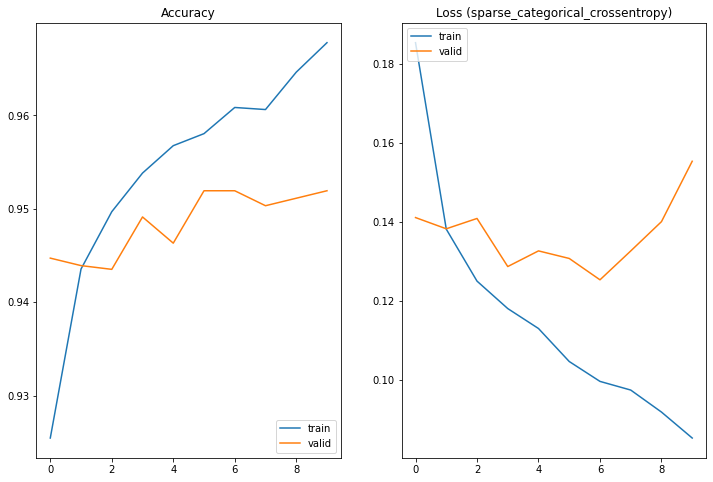

In [51]:
def show_graphs(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend(loc='upper left')
    plt.title('Loss (sparse_categorical_crossentropy)')

    plt.show()
    
show_graphs(history)

In [52]:
mobilenet_model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)
mobilenet_model.trainable = False # freeze convolutional layers

17227776/17225924 [==============================] - 4s 0us/step


In [53]:
dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1000, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

In [54]:
model2 = tf.keras.models.Sequential([
    mobilenet_model,
    dense_model
])

In [55]:
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
EPOCHS = 10
train_data.reset()
valid_data.reset()
history = model2.fit_generator(
    train_data,
    steps_per_epoch=train_data.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_data,
    validation_steps=valid_data.n // BATCH_SIZE
)

C:\Users\prans\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
703/703 [==============================] - 32s 42ms/step - loss: 0.1795 - accuracy: 0.9372 - val_loss: 0.0724 - val_accuracy: 0.9752
Epoch 2/10
703/703 [==============================] - 30s 43ms/step - loss: 0.0826 - accuracy: 0.9692 - val_loss: 0.0616 - val_accuracy: 0.9728
Epoch 3/10
703/703 [==============================] - 31s 44ms/step - loss: 0.0729 - accuracy: 0.9726 - val_loss: 0.0678 - val_accuracy: 0.9712
Epoch 4/10
703/703 [==============================] - 31s 44ms/step - loss: 0.0639 - accuracy: 0.9760 - val_loss: 0.0919 - val_accuracy: 0.9671
Epoch 5/10
703/703 [==============================] - 31s 45ms/step - loss: 0.0626 - accuracy: 0.9763 - val_loss: 0.0626 - val_accuracy: 0.9768
Epoch 6/10
703/703 [==============================] - 33s 47ms/step - loss: 0.0530 - accuracy: 0.9798 - val_loss: 0.0585 - val_accuracy: 0.9800
Epoch 7/10
703/703 [==============================] - 34s 48ms/step - loss: 0.0486 - accuracy: 0.9817 - val_loss: 0.0615 - val_accuracy:

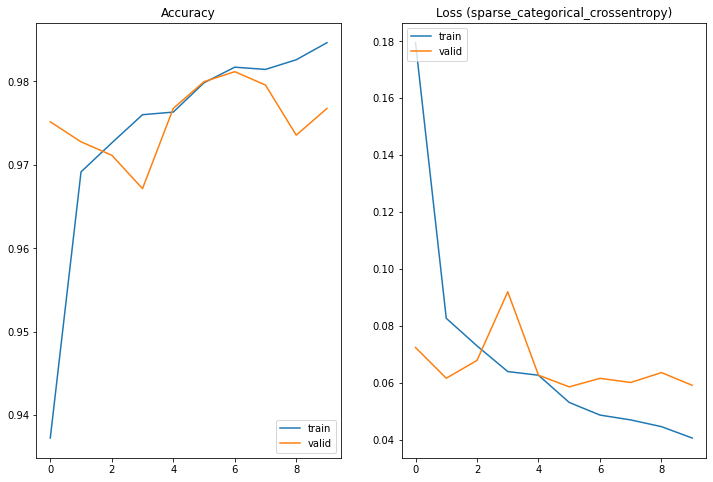

In [57]:
show_graphs(history)


In [58]:
IMAGE_SHAPE = 224
example_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)
example_x, example_y = example_data.next()
example_classes = list(example_data.class_indices.keys())
example_y_classes = [example_classes[int(i)] for i in example_y]

Found 22500 images belonging to 2 classes.


In [59]:
mobilenet_native = tf.keras.applications.mobilenet.MobileNet(
    include_top=True,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)
mobilenet_native.compile()
example_pred = mobilenet_native.predict(
    example_x
)

17227776/17225924 [==============================] - 2s 0us/step


In [60]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
)
imagenet_labels = np.array(open(labels_path).read().splitlines())
result = imagenet_labels[np.argmax(example_pred, axis=1)]

16384/10484 [==============================================] - 0s 0us/step


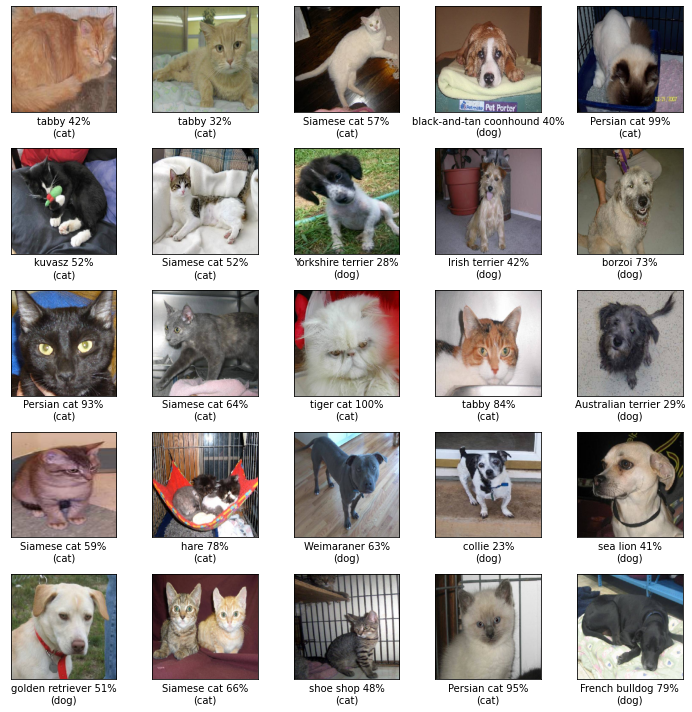

In [61]:
NUM_ROWS = 5
NUM_COLS = 5
NUM_IMAGES = NUM_COLS * NUM_ROWS
plt.figure(figsize=(2*NUM_COLS, 2*NUM_ROWS))
for i in range(NUM_IMAGES):
    plt.subplot(NUM_ROWS, NUM_COLS, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(example_x[i], cmap=plt.cm.binary)
    plt.xlabel('{} {:.0%}\n({})'.format(result[i], np.max(example_pred[i]), example_y_classes[i]))
plt.tight_layout()
plt.show()